In [ ]:
%pip install --upgrade --quiet pypdf langchain-core langgraph langchain_openai langchain_anthropic langchain-community scikit-learn bs4 tavily-python

### Lesson 1: Context and Setup

We'll build a research assistant that combines 3 themes: 

1) `Report Generation` -- [Reports provide greater value than question-answering tools used in many RAG systems](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/). This is because reports offer more than just answers; they are more refined tools for decision-making. Reports can save costs by replacing the need for multiple employees or expensive processes.

2) `Automating multi-step research workflows` -- There are some interesting examples of AI-mediated workflows that replace knowlege work. For example, [deal flow automation for VCs](https://x.com/MaxBrodeurUrbas/status/1806380947606253960) that analyzes pitch decks (e.g., extracts all metrics, finds founder LinkedIns + extracts their background, writes to Notion).

3) `Multi-perspective AI assistants` -- A generally powerful approach, as seen in papers like [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb), is to create AI assistants that take on various roles and have them simultanously research about a topic from different angles.

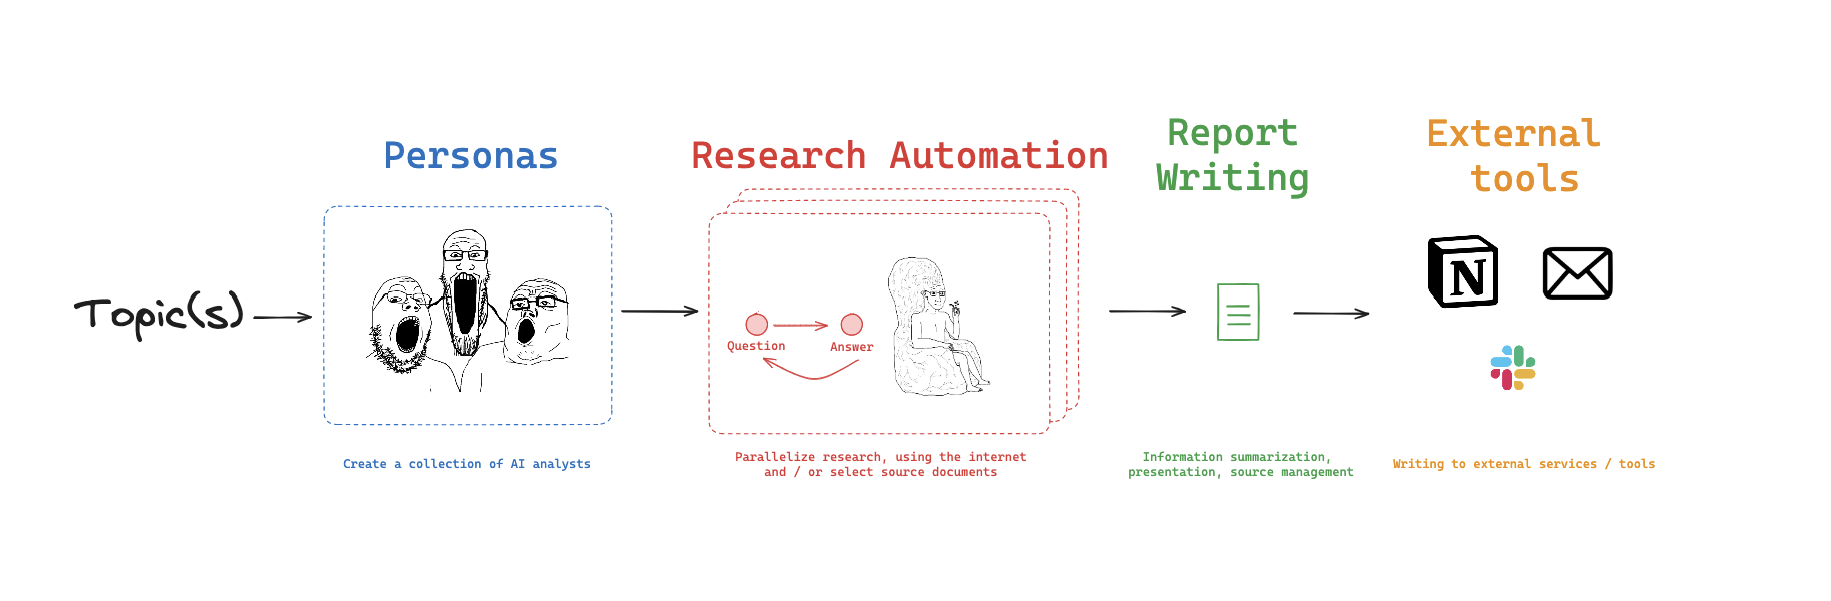

Let's specify an overall topic.

In [11]:
# Overall topic
topic = "Interesting and non-obvious insights based upon the Meta LLlama3.1 open source LLM work"

#### Personas

Next, we want to create our analysts. 

Here, we have some options:

1. Prompt an LLM with a few specific themes

2. Let an LLM choose the specifics based upon some provided context

We choose option 2. We have many options for adding context here to guide the process. 

This can include comments from localLLaMA reddit posts or from Zuck's blog post.
 
The idea here is that we use context to select more specific and interesting focus ares for our analysts. 

In [8]:
from langchain_community.document_loaders import WebBaseLoader

# Load Mark's Letter from the web 
url = "https://about.fb.com/news/2024/07/open-source-ai-is-the-path-forward/"
ANALYST_TOPIC_GENERATION_CONTEXT_BLOG = WebBaseLoader(url).load()

Data model for our analysts.

In [3]:
from typing import List, Optional
from langchain_core.pydantic_v1 import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst.", pattern=r"^[a-zA-Z0-9_-]{1,64}$"
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

State for our research agent.

`ResearchGraphState` will be the overall state.

`InterviewState` will be the state for each specific interview between our AI analyst and AI expert.

In [21]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class ResearchGraphState(TypedDict):
    analysts: List[Analyst]
    interviews: Annotated[list, operator.add] # ... and "outer state"
    reports: Annotated[list, operator.add] # ... and "outer state"
    final_report: str
    analyst_feedback: str 
    editor_feedback: str 

class InterviewState(TypedDict):
    topic: str
    messages: Annotated[List[AnyMessage], add_messages]
    analyst: Analyst
    editor_feedback: str
    interviews: list # This key is duplicated between "inner state" ...
    reports: list # This key is duplicated between "inner state" ...

Generate our analysts.

In [ ]:
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")
_set_env("OPENAI_API_KEY")

Choose our LLM.

We can select any [chat model that support tool use](https://python.langchain.com/v0.1/docs/integrations/chat/)!

In [9]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

Now, we can create our set of research analysts.

In [14]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.runnables import chain as as_runnable
from langchain_core.messages import AIMessage, HumanMessage

gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """
            You are tasked with creating a set of AI analyst personas. 
            
            Follow these instructions carefully:

            1. First, review the research topic:
            
            {topic}
            
            2. Examine any documents that have been optionally provided to guide creation of the analysts:
            
            {documents}

            3. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
            
            {analyst_feedback}  
            
            4. Think carefully about anything provided about to guide analst creation related to the research topic.
            
            5. Determine the most interesting themes and questions. 
            
            6. Assign AI analyst persona to each themes and / or question. 
            
            7. Choose the top {max_analysts} themes. The maximum number of personas you should create is:
            
            {max_analysts}""",
            
        ),
    ]
)

@as_runnable
def generate_analysts(state: ResearchGraphState):
    """ Node to generate analysts """

    # Get topic and max analysts from state
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    analyst_feedback = state.get("analyst_feedback", "")

    # Generate analysts
    gen_perspectives_chain = gen_perspectives_prompt | llm.with_structured_output(Perspectives)
    perspectives = gen_perspectives_chain.invoke({"documents": ANALYST_TOPIC_GENERATION_CONTEXT_BLOG, 
                                                  "topic": topic, 
                                                  "analyst_feedback": analyst_feedback, 
                                                  "max_analysts": max_analysts})
    
    # Write the list of analysis to state
    return {"analysts": perspectives.analysts}

In [17]:
from pprint import pprint

# Test
initial_state = {"topic": topic, 
                 "analyst_feedback": "Make sure to include an analyst on the training strategy -- e.g., # of GPUs and network.",
                 "max_analysts": 3}

perspectives = generate_analysts.invoke(initial_state)
for a in perspectives['analysts']:
    print("---")
    pprint(a.description)
    print("---")

---
('Dr. Martinez focuses on the technical aspects of training large language '
 'models, including the number of GPUs required, network infrastructure, and '
 "cost-efficiency. She is particularly interested in how Llama 3.1's "
 'open-source nature can optimize training processes and reduce costs for '
 'developers.')
---
---
('Dr. Green specializes in the ethical implications and safety concerns of '
 'deploying open-source AI models. He examines the potential for both '
 'unintentional and intentional harm, and how open-source models like Llama '
 '3.1 can be made safer through transparency and community scrutiny.')
---
---
('Dr. Nair focuses on the broader ecosystem that supports the deployment and '
 'fine-tuning of open-source AI models. She is interested in how partnerships '
 'with companies like AWS, Databricks, and NVIDIA can enhance the capabilities '
 'and adoption of Llama 3.1, making it the industry standard.')
---


#### Question-Asking

Now, we have a set of analysts!

Next, can simply build a question-asking prompt for an analyst.

In [22]:
gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """You are an experienced analyst tasked with interviewing an expert to learn about a specific topic. 

            Your goal is boil down to non-obvious and specific insights related to your topic:

            1. Non-obvious: Insights that people will find surprising.
            
            2. Specific: Insights that avoid generalities and include specific examples from the exprt.
    
            Here is your topic of focus and set of goals: {persona}
            
            Begin by introducing yourself using a name that fits your persona, and then ask your question.

            Continue to ask questions to drill down and refine your understanding of the topic.
            
            When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

            Remember to stay in character throughout your response, reflecting the persona and goals provided to you.""",
        
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

@as_runnable
def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    gen_question_chain = gen_qn_prompt.partial(persona=analyst.persona) | llm   
    result = gen_question_chain.invoke({"messages": messages})
    
    # Write messages to state
    return {"messages": [result]}

# Test
messages = [HumanMessage(f"So you said you were researching {topic}?")]

# Analyst to test 
i = 0
interview_state = {"analyst": perspectives["analysts"][i], "messages": messages}
question = generate_question.invoke(interview_state)
messages.extend(question['messages'])
messages

[HumanMessage(content='So you said you were researching Interesting and non-obvious insights based upon the Meta LLlama3.1 open source LLM work?'),
 AIMessage(content="Hello, Dr. Martinez. My name is Alex Thompson, and I'm an analyst keen on understanding the intricacies of training large language models, particularly focusing on Meta's Llama 3.1. Thank you for taking the time to speak with me today.\n\nTo start, could you share some non-obvious insights about the number of GPUs required for training Llama 3.1? Specifically, are there any surprising findings related to GPU utilization that developers might not be aware of?", response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 277, 'total_tokens': 374}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_c9aa9c0491', 'finish_reason': 'stop', 'logprobs': None}, id='run-407ffbc0-08b4-4650-a7c1-397f1518ecad-0', usage_metadata={'input_tokens': 277, 'output_tokens': 97, 'total_tokens': 374})]

#### Expert

Next, let's build an expert that can answer questions! 

Here, we can simply supply it with relevant context.

For ease, let's just given it access to a technical blog post about llama 3.1.

In [23]:
from langchain_community.document_loaders import WebBaseLoader

# Load a technical blog post from the web 
url = "https://ai.meta.com/blog/meta-llama-3-1/"
EXPERT_CONTEXT_BLOG = WebBaseLoader(url).load()

In [29]:
gen_expert_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """You are an expert on the topic of {topic}.
            
            You are being interviewed by an analyst who focused on learning about a specific topic. 
            
            Your goal is to share non-obvious and specific insights related to your topic:

            1. Non-obvious: Insights that people will find surprising and therefore interesting.
            
            2. Specific: Insights that avoid generalities and include specific examples from the exprt.

            Here is the context you should use to inform your answers:
            {context}

            When answering questions, follow these guidelines:
            
            1. Use only the information provided in the context. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.
                     
            2. If a question cannot be answered based on the given context, state that you don't have enough information to provide a complete answer.
            
            Remember, your ultimate goal is to help the analyst drill down to specific and non-obvious insights about the topic.""",
            
        ),
        
            MessagesPlaceholder(variable_name="messages", optional=True),
        ]
)

@as_runnable
def generate_answer(state: InterviewState):
    """ Node to answer a question """

    # Get state
    topic = state["topic"]
    messages = state["messages"]
   
    # Answer question
    answer_chain = gen_expert_prompt | llm
    answer = answer_chain.invoke({'messages': messages,
                                  'topic': topic,
                                  'context': EXPERT_CONTEXT_BLOG})  
    
    # Name the message as coming from the expert
    # We use this later to count the number of times the expert has answered
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

# Test
interview_state = {"analyst": perspectives["analysts"][i], 
                   "topic": topic,
                   "messages": messages}

answer = generate_answer.invoke(interview_state)
messages.extend(answer['messages'])
messages

[HumanMessage(content='So you said you were researching Interesting and non-obvious insights based upon the Meta LLlama3.1 open source LLM work?'),
 AIMessage(content="Hello, Dr. Martinez. My name is Alex Thompson, and I'm an analyst keen on understanding the intricacies of training large language models, particularly focusing on Meta's Llama 3.1. Thank you for taking the time to speak with me today.\n\nTo start, could you share some non-obvious insights about the number of GPUs required for training Llama 3.1? Specifically, are there any surprising findings related to GPU utilization that developers might not be aware of?", response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 277, 'total_tokens': 374}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_c9aa9c0491', 'finish_reason': 'stop', 'logprobs': None}, id='run-407ffbc0-08b4-4650-a7c1-397f1518ecad-0', usage_metadata={'input_tokens': 277, 'output_tokens': 97, 'total_tokens': 374}),
 AIMessage(cont